In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import time

from IPython.display import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [3]:
def open_photos(path='train/book',orig = 'marker.jpg', scale = 0.25):
    images = []
    names = os.listdir(path)
    names = list(filter(lambda x: str(x[-4:]) == ".jpg", names))
    names.sort(key = lambda x: int(x[:-4]))
    for filename in names:
        img = cv2.imread(os.path.join(path,filename), 0)
        if img is not None:
            img = cv2.resize(img, (960, 1280)) 
            images.append(img) 
    
    image = cv2.imread(orig, 0)
    image = cv2.resize(image, (960, 1280))
    return images, names, image
    
test, names, train = open_photos(scale =0.25)

In [46]:
def feature_matching_pair(marker, photo):
    method = cv2.SIFT_create()
    
    train = cv2.cvtColor(marker, cv2.COLOR_BGR2GRAY)
    test = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    
    kp1, des1 = method.detectAndCompute(train, None)
    kp2, des2 = method.detectAndCompute(test, None)
  
    MIN_MATCH_COUNT = 10
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance / n.distance <= 0.8:
            good.append(m)
            
    if len(good)>=MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5)
        matchesMask = mask.ravel().tolist()

        h,w = train.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        
        repl = cv2.imread('repl.jpg')
        temp = cv2.cvtColor(repl, cv2.COLOR_BGR2GRAY)
        
        result = cv2.warpPerspective(temp, M, (repl.shape[1], repl.shape[0]))
        repl = cv2.warpPerspective(repl, M, (repl.shape[1], repl.shape[0]))
        
        
        ret, mask = cv2.threshold(result, 10, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        
        img1_bg = cv2.bitwise_and(photo, photo, mask=mask_inv)
        img2_fg = cv2.bitwise_and(repl, repl, mask=mask)
        
        result = cv2.add(img1_bg, img2_fg)
        
        return result

   
    


In [64]:
def do_it(photo_path):
    marker = cv2.imread('marker.jpg')
    marker = cv2.resize(marker, (960, 1280))
    photo =  cv2.imread(photo_path)
    photo = cv2.resize(photo, (960, 1280))
    result = feature_matching_pair(marker, photo)
    cv2.imwrite('peow.jpg', result)
    

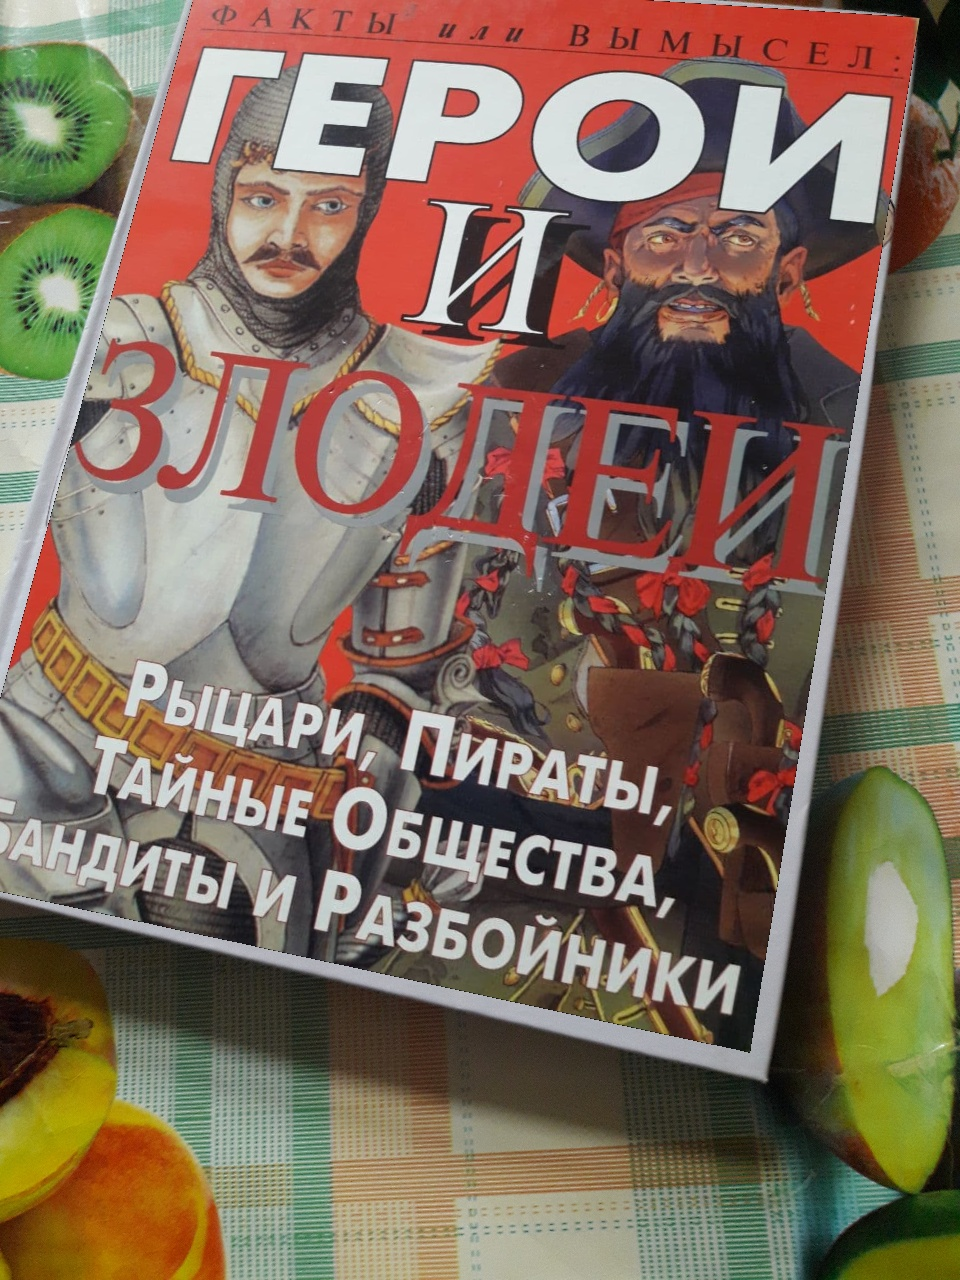

In [65]:
do_it('train/book/13.jpg')
Image('peow.jpg', width = 400, height = 300)